Link to website: https://albert-moller.github.io

Link to explainer notebook: https://github.com/albert-moller/albert-moller.github.io

Group members: Albert Frisch Møller (s214610) and Mark Andrawes (s214654)

For this final assignment each group member contributed equally to every aspect of the assignment

# **Explainer Notebook**

## **Motivation**

Our ready-made dataset contains all tweets made by the US Senators during the first year of the Biden administration (2021). We chose this particular dataset as we wanted to explore the communities within the US Senate, as well as the topics being discussed within them. The structure of this dataset allows us to explore this, as it provides a way to understand the relationships between the US Senators through social media interactions. Our goal for the end user's experience is to...

## **Basic stats**

To understand the dataset better, we will load the dataset into Pandas DataFrame and display a sample:

In [1]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd

dataset = load_dataset('m-newhauser/senator-tweets')
datasets_to_combine = [dataset[split] for split in dataset.keys()]
combined_dataset = concatenate_datasets(datasets_to_combine)
df = combined_dataset.to_pandas()

df.head()

/Users/albertmoller/anaconda3/envs/comsocsci2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,date,id,username,text,party,labels,embeddings
0,2021-10-13 19:47:44,1448374915636383745,SenatorHassan,Happy th birthday to the @USNavy! The strength...,Democrat,1,"[-0.026915843, 0.087234065, 0.018707331, -0.03..."
1,2021-06-30 14:53:13,1410250073003462656,SenatorMenendez,The greatest generation's investment in infras...,Democrat,1,"[0.024044158, -0.0048382296, 0.09699756, -0.03..."
2,2021-08-08 01:11:29,1424176405881966599,SenBillCassidy,"Thanks to @SenTedCruz and @SenatorWarnock, th...",Republican,0,"[-0.002620128, -0.042515174, 0.065084696, 0.01..."
3,2021-04-14 14:02:49,1382333523567185921,SenBlumenthal,/ To get lasting change we cant just lock up t...,Democrat,1,"[-0.045103785, 0.0762336, -0.011798679, -0.044..."
4,2021-12-11 16:06:38,1469700160934621188,SenatorBraun,Today were celebrating years of the Hoosier st...,Republican,0,"[-0.038810886, 0.11611319, 0.06621017, -0.0184..."


The sample above contains the first five rows of the dataset. As shown, it contains the following columns: date, id, username, text, party, labels, and embeddings. Below is a brief description of what each of these columns contains:

**date**: Time and day of when the tweet was posted.  
**id**: A unique tweet identifier.  
**Username**: The username of the senator who posted the tweet.  
**text**: The tweet text.  
**party**: The party of the Senator who posted the tweet.  
**labels**: Provides the same information as party - "0" indicates the senator is a Republican, "1" indicates the Senator is a Democrat.  
**embeddings**: A list of embeddings for the tweet.  

### **Data cleaning and preprocessing**  
Seeing as the 'labels' column provides the same information as the 'party' column, the 'labels' column will be removed. Additionally, the 'embeddings' column will be removed as it will not be used in the analysis.

In [2]:
df = df.drop(['labels', 'embeddings'], axis=1)
df.head()

,date,id,username,text,party
0,2021-10-13 19:47:44,1448374915636383745,SenatorHassan,Happy th birthday to the @USNavy! The strength...,Democrat
1,2021-06-30 14:53:13,1410250073003462656,SenatorMenendez,The greatest generation's investment in infras...,Democrat
2,2021-08-08 01:11:29,1424176405881966599,SenBillCassidy,"Thanks to @SenTedCruz and @SenatorWarnock, th...",Republican
3,2021-04-14 14:02:49,1382333523567185921,SenBlumenthal,/ To get lasting change we cant just lock up t...,Democrat
4,2021-12-11 16:06:38,1469700160934621188,SenatorBraun,Today were celebrating years of the Hoosier st...,Republican


### **Dataset stats**
Having preprocessed the data, let us now investigate the basic properties of the dataset. This includes the number of rows (corresponding to the number of tweets), the number of unique usernames (corresponding to the number of senators), and the number of democrats and republicans. 

In [3]:
print("Number of rows (tweets): ", len(df))
print("Number of unique usernames (senators): ", len(df['username'].unique()))
print("Number of senators that are Democrats: ", len(df[df['party'] == 'Democrat']['username'].unique()))
print("Number of senators that are Republicans: ", len(df[df['party'] == 'Republican']['username'].unique()))

Number of rows (tweets):  99693
Number of unique usernames (senators):  99
Number of senators that are Democrats:  50
Number of senators that are Republicans:  49


As shown above, the dataset contains 99693 tweets, posted by a total of 99 senators. Out of these senators, 50 were Democrats and 49 were Republicans.

## **Tools, theory and analysis**

### **Building the network**

Having gained a good understanding of the dataset, we will now use it to build a network using the networkx library. The network will consist of nodes representing the senators, and edges representing mentions within the tweets. So, if a senator mentions another in a tweet, an edge is created between them. It is important to note that the edges are weighted and that each node has a 'party' attribute corresponding to their party.  

Seeing as many of the mentions in the tweets are not related to another senator, the text within the tweets were split by '@' and each split was checked against the usernames of the senators. 

In [4]:
#Build the US Senate twitter network
from collections import defaultdict
import networkx as nx
G = nx.Graph()
edges = defaultdict(int)

for index, row in df.iterrows():
    sender = row['username']
    text = row['text']
    unique_usernames = set(df['username'].unique())
    
    tokens = text.split('@')[1:] 
    
    for token in tokens:
        potential_username = token.split()[0] if ' ' in token else token
        if potential_username in unique_usernames and potential_username != sender:
            edge = tuple(sorted((sender, potential_username)))
            edges[edge] += 1

for (source, target), weight in edges.items():
    G.add_edge(source, target, weight=weight)

for node in G.nodes:
    party = df[df['username'] == node]['party'].values[0]
    G.nodes[node]['party'] = party

### **Basic stats about the network**
Having built the network, we find the number of nodes and the number of edges. Additionally, the probability of an edge existing betwen any two nodes in the graph is found using Equation 3.2 from Chapter 3, and the average degree of the nodes in the graph was calculated using Equation 3.3 from Chapter 3. 

In [5]:
node_count_real = G.number_of_nodes()
edge_count_real = G.number_of_edges()

print(f"Number of nodes: {node_count_real}")
print(f"Number of edges: {edge_count_real}")

#Calculate p using the formula p = 2*<L>/(N*(N-1)) obtained by isolating for p in equation 3.2 from Chapter 3
p = 2 * edge_count_real / (node_count_real*(node_count_real-1))
print(f"Probability p is {p}")

#Calculate the average degree using the formula <k> = p*(N-1) (equation 3.3 from Chapter 3)
average_degree = p*(node_count_real-1)
print(f"Average degree <k> is {average_degree}")

Number of nodes: 99
Number of edges: 1608
Probability p is 0.33147804576376005
Average degree <k> is 32.484848484848484


As expected, the graph contains 99 nodes corresponding to the 99 senators in the dataset, and the graph contains 1608 edges in total. The probability of an edge existing between two given nodes was found to be 0.33, and the average degree was found to be 32.5.

### **Building a random network**
To be able to understanding the properties about the network better, we can compare them to those of a random network that contains the same number of nodes. We build this random network below:

In [6]:
import numpy as np
def random_network(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1,N):
            if np.random.uniform(0,1) < p:
                G.add_edge(i,j)
    return G

G_random = random_network(node_count_real, p)

### **Visualizing the networks**
Having built our Senator network and a random network for comparison, we can visualize both using the netwulf package:

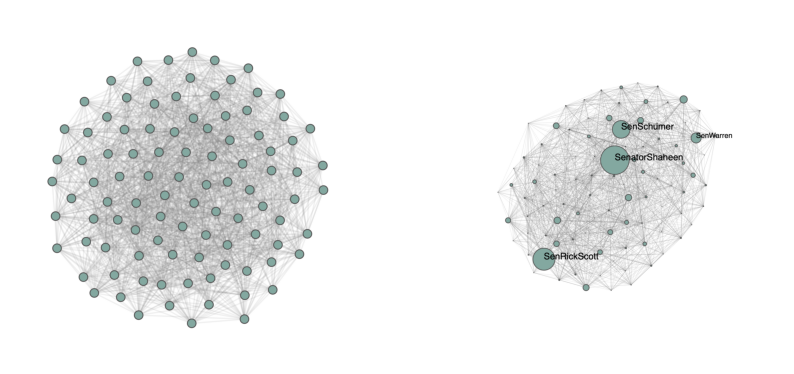

In [7]:
#Visualizing the networks
import netwulf as nw
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#nw.visualize(G)
#nw.visualize(G_random)
def display_images_side_by_side(image_paths):
    plt.figure(figsize=(10, 5))
    for i, image_path in enumerate(image_paths, start=1):
        img = mpimg.imread(image_path)
        plt.subplot(1, len(image_paths), i)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

image_paths = ['random_network.png', 'us_senate_twitter_network.png']
display_images_side_by_side(image_paths)

### **Comparing the networks**
We compare the connected components of the two networks, as well as the number of isolated nodes:

In [8]:
connected_components = list(nx.connected_components(G_random))
largest_connected_component = max(connected_components, key = len)
largest_subgraph_random = G_random.subgraph(largest_connected_component)

connected_components = list(nx.connected_components(G))
largest_connected_component = max(connected_components, key = len)
largest_subgraph_real = G.subgraph(largest_connected_component)

#Compute size of the largest connected component
print(f"Size of the largest connected component (random network) is {largest_subgraph_random.number_of_nodes()}")
print(f"Size of the largest connected component (real network) is {largest_subgraph_real.number_of_nodes()}")

#Compute the number of isolated components
isolated_n = list(nx.isolates(G_random))
number_of_isolated_nodes = len(isolated_n)
print(f"Number of isolated nodes in the random network: {number_of_isolated_nodes}")

isolated_n = list(nx.isolates(G))
number_of_isolated_nodes = len(isolated_n)
print(f"Number of isolated nodes in the real network: {number_of_isolated_nodes}")

Size of the largest connected component (random network) is 99
Size of the largest connected component (real network) is 99
Number of isolated nodes in the random network: 0
Number of isolated nodes in the real network: 0


From this, we see that both the random network and the Senators network are fully connected, as the larged connected component involves all 99 nodes in both networks. Thus, both networks also contains no isolated nodes.  

We now investigate the degree distributions of the two networks:

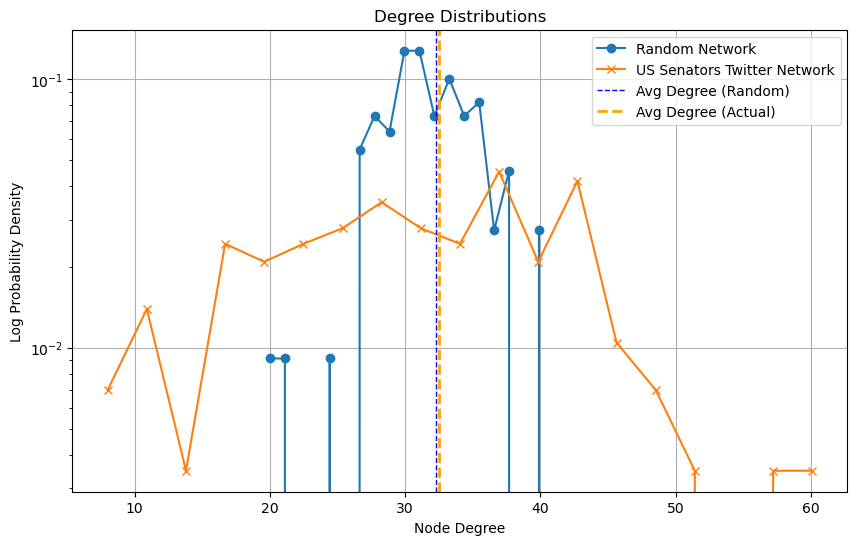

In [9]:
#Compute degree distribution for the random network:
node_degrees_random = [degree for node, degree in G_random.degree()]
max_node_degree = max(node_degrees_random)
min_node_degree = min(node_degrees_random)
bins = np.linspace(min_node_degree, max_node_degree, 20)
degree_distribution_random, edges_random = np.histogram(node_degrees_random, bins=bins, density=True)

#Compute degree distribution for the real network:
node_degrees_real = [degree for node, degree in G.degree()]
max_node_degree = max(node_degrees_real)
min_node_degree = min(node_degrees_real)
bins = np.linspace(min_node_degree, max_node_degree, 20)
degree_distribution_real, edges_real = np.histogram(node_degrees_real, bins=bins, density=True)

# Plot both degree distributions on the same figure using line plots
plt.figure(figsize=(10, 6))
plt.plot(edges_random[:-1], degree_distribution_random, linestyle='-', marker='o', label='Random Network')
plt.plot(edges_real[:-1], degree_distribution_real, linestyle='-', marker='x', label='US Senators Twitter Network')
avg_degree_random = np.mean(node_degrees_random)
avg_degree_actual = np.mean(node_degrees_real)
plt.axvline(avg_degree_random, color='blue', linestyle='dashed', linewidth=1, label='Avg Degree (Random)')
plt.axvline(avg_degree_actual, color='orange', linestyle='dashed', linewidth=2, label='Avg Degree (Actual)')
plt.xlabel('Node Degree')
plt.ylabel('Log Probability Density')
#plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distributions')
plt.legend()
plt.grid(True)

### **Assortativity based on political party**
To investigate how the political party attribute of the nodes influences the formation of links within the Senator network, we calculate the assortativity coefficient based on the party attribute:

In [10]:
def assortativity_coeffecient(G, attribute: str):
    attribute_dict = nx.get_node_attributes(G, attribute)
    assert len(attribute_dict) == G.number_of_nodes()
    attributes = list(set(attribute_dict.values()))
    attribute_indices = {attr: i for i, attr in enumerate(attributes)}
    e = np.zeros((len(attributes), len(attributes)))

    for a, b in G.edges():
        index_a = attribute_indices[attribute_dict[a]]
        index_b = attribute_indices[attribute_dict[b]]
        e[index_a][index_b] += 1
        e[index_b][index_a] += 1
    
    e = e / e.sum()
    a, b = e.sum(axis=1), e.sum(axis=0)
    r = (np.sum(np.diag(e)) - np.sum(a * b)) / (1 - np.sum(a * b))
    return r 
        
r = assortativity_coeffecient(G, "party")
print("Assortativity coefficient based on party attribute:", round(r,3))

Assortativity coefficient based on party attribute: 0.262


An assortativity coefficient of 0.262 based on the party attribute, in the context of the Senator network, indicates that there is a moderate tendency towards forming links within the same polticial party, but there are still a significant number of links across the two parties. 

### **Analyzing assortativity in random networks using configuration model**
We now assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model. 

In [11]:
import random
from tqdm import tqdm

def configuration_model(G, num_swaps):
    RG = G.copy()
    edges = list(RG.edges()) 
    edge_count = len(edges)
    for _ in range(num_swaps):
        e1_idx, e2_idx = random.sample(range(edge_count), 2)
        e1, e2 = edges[e1_idx], edges[e2_idx]
        u, v = e1
        x, y = e2

        if random.random() < 0.5:
            u, v = v, u

        if u != y and v != x and not RG.has_edge(u, y) and not RG.has_edge(x, v):
            RG.remove_edge(*e1)
            RG.remove_edge(*e2)
            RG.add_edge(u, y)
            RG.add_edge(x, v)
            edges[e1_idx] = (u, y)
            edges[e2_idx] = (x, v)

    return RG

num_swaps = G.number_of_edges() * 10
randomized_graph = configuration_model(G, num_swaps)

#Assert that the degrees of the nodes in the original network and the configuration model remain the same
original_degrees = dict(G.degree())
randomized_degrees = dict(randomized_graph.degree())
degrees_match = all(original_degrees[node] == randomized_degrees[node] for node in G.nodes())
print(f"Do the degrees match? {degrees_match}")

Do the degrees match? True


In [12]:
#Generate 100 random networks:
assortativity_coeffecients = []
num_swaps = G.number_of_edges() * 10

for _ in tqdm(range(100)):
    random_network = configuration_model(G, num_swaps)
    r = assortativity_coeffecient(random_network, "party")
    assortativity_coeffecients.append(r)

original_assortativity = assortativity_coeffecient(G, "party")
print(f"Assortativity coeffecient of the original network is {original_assortativity}")

  3%|▎         | 3/100 [00:00<00:03, 27.88it/s]

100%|██████████| 100/100 [00:03<00:00, 30.08it/s]

Assortativity coeffecient of the original network is 0.26200368942430813


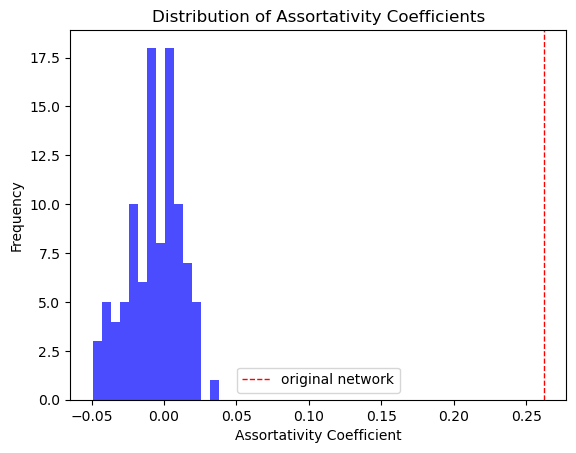

In [13]:
max_assortativity = max(assortativity_coeffecients)
min_assortativity = min(assortativity_coeffecients)
bins = np.linspace(min_assortativity, max_assortativity, 15)
plt.hist(assortativity_coeffecients, bins=bins, color='blue', alpha=0.7)
plt.axvline(original_assortativity, color='red', linestyle='dashed', linewidth=1, label = "original network")
plt.title('Distribution of Assortativity Coefficients')
plt.xlabel('Assortativity Coefficient')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The plot above shows the distribution of assortativity coefficients for 100 random networks and the assortativity coefficient of the US Senator network. From observing the distribution, it is evident that connections within the same party are indeed significantly higher than chance. This is because the assortativity coefficient of the US Senator network is significantly larger than that of random networks. The large value, namely 0.262, indicates that there is a high likelihood that any two nodes from the same party being connected. 

### **Analyzing assortativity by degree**
We now calculate degree assortativity for the network and compare it to that of 100 random networks generated using the configuration model.

In [14]:
def degree_assortativity(G):
    degrees = dict(G.degree())
    
    # Calculate the joint probability distribution of the degrees of the nodes on either side of an edge
    M = np.zeros((max(degrees.values())+1, max(degrees.values())+1))
    for u, v in G.edges():
        M[degrees[u]][degrees[v]] += 1
        M[degrees[v]][degrees[u]] += 1 

    # Normalize the matrix
    M /= M.sum()
    
    a_i = M.sum(axis=1)
    b_i = M.sum(axis=0)
    
    assortativity = (np.trace(M) - np.dot(a_i, b_i)) / (1 - np.dot(a_i, b_i))
    return assortativity

#Generate 100 random networks:
degree_assortativities = []
num_swaps = G.number_of_edges() * 10

for _ in tqdm(range(100)):
    random_network = configuration_model(G, num_swaps)
    degree_assort = degree_assortativity(random_network)
    degree_assortativities.append(degree_assort)

original_degree_assortativity= degree_assortativity(G)
print(f"Degree assortativity of the original network is {original_degree_assortativity}")

100%|██████████| 100/100 [00:03<00:00, 29.26it/s]

Degree assortativity of the original network is -0.007632350358652925


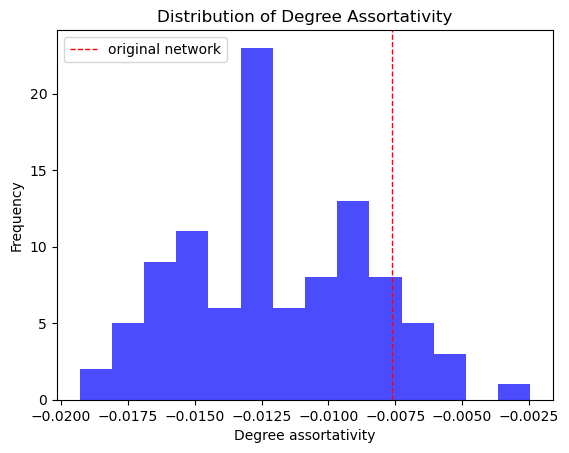

In [15]:
max_assortativity = max(degree_assortativities)
min_assortativity = min(degree_assortativities)
bins = np.linspace(min_assortativity, max_assortativity, 15)
plt.hist(degree_assortativities, bins=bins, color='blue', alpha=0.7)
plt.axvline(original_degree_assortativity, color='red', linestyle='dashed', linewidth=1, label = "original network")
plt.title('Distribution of Degree Assortativity')
plt.xlabel('Degree assortativity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

As indicated by the red dashed line, the degree assortativity of the US senator network is not significantly different to the degree assortativity that would be expected by chance. This indicates that high-degree Senators are not necessarily more likely to connect with other high-degree senators. 

### **Finding central nodes**
We now find the 5 most central senators according to the closeness centrality.

In [16]:
closeness_centrality = nx.closeness_centrality(G)
top5_closeness_centralities = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 senators by closeness centrality:")
for scientist, centrality in top5_closeness_centralities:
    print(f"Senator {scientist}: {centrality}")

Top 5 senators by closeness centrality:
Senator SenKevinCramer: 0.7368421052631579
Senator SenatorShaheen: 0.7101449275362319
Senator SenRonJohnson: 0.6805555555555556
Senator SenatorDurbin: 0.6758620689655173
Senator SenSchumer: 0.6712328767123288


Given that closeness centrality measures how close a node is to all other nodes in the network, the 5 senators with highest closeness centrality likely play a critical role in the political discussions taking place on twitter. These senators likely connect with many others on twitter and tend to collaborate with others often. This indicates that they are influential and widely recognized on the social media platform. 

We now find the 5 most central senators according to **eigenvector centrality**:

In [17]:
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sort and get the top 5
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Senators by eigenvector centrality:")
for scientist, centrality in sorted_eigenvector:
    print(f"Senator {scientist}: {centrality}")


Top 5 Senators by eigenvector centrality:
Senator SenKevinCramer: 0.18132664454208938
Senator SenatorShaheen: 0.16045237427382908
Senator SenatorDurbin: 0.14836742407584524
Senator SenSchumer: 0.14270033925957953
Senator SenRonJohnson: 0.1422456533237999


Interestingly, we see that the top 5 senators by centrality and by eigenvector centrality are the same, but in a different order. We can investigate the relationship between closeness centrality of nodes and their degree by plotting:

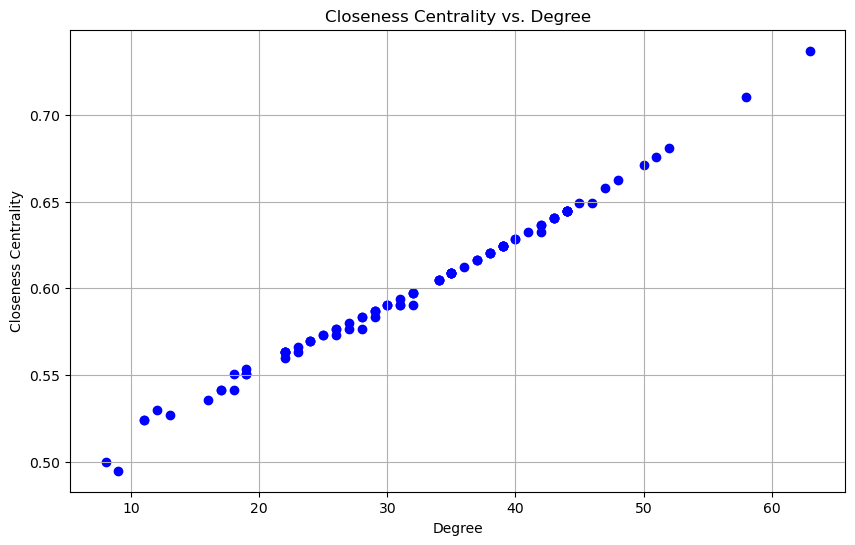

In [18]:
degrees = dict(G.degree())
closeness_values = list(closeness_centrality.values())
degree_values = list(degrees.values())

# Plotting closeness centrality of nodes vs their degree
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, closeness_values, color='blue')
plt.title('Closeness Centrality vs. Degree')
plt.xlabel('Degree')
plt.ylabel('Closeness Centrality')
plt.grid(True)
plt.show()

The plot above shows a very strong correlation that suggests that nodes with higher degrees almost always have higher closeness centrality. Generally, this was expected as more direct connections a node has with other nodes, the more central the node is in the network - leading to higher closeness centrality. 

We now plot the relationship between eigenvector centrality and degree:

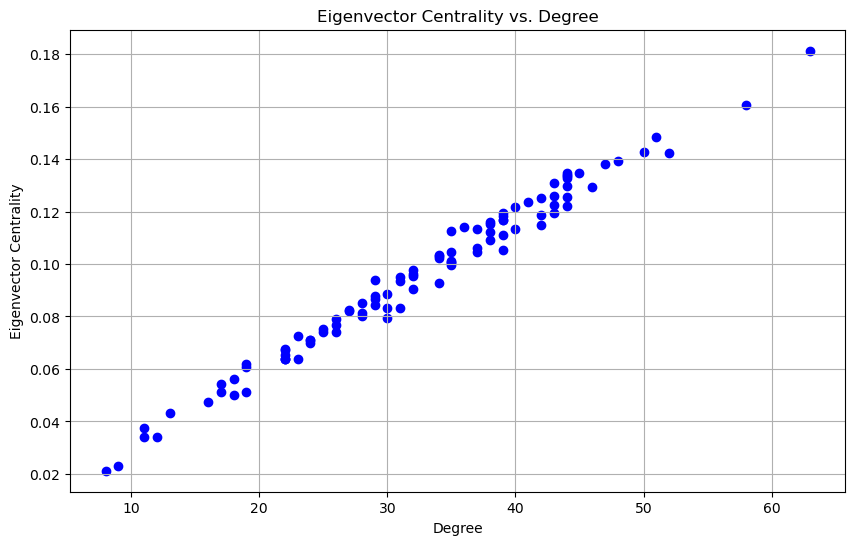

In [19]:
degrees = dict(G.degree())
closeness_values = list(eigenvector_centrality.values())
degree_values = list(degrees.values())

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, closeness_values, color='blue')
plt.title('Eigenvector Centrality vs. Degree')
plt.xlabel('Degree')
plt.ylabel('Eigenvector Centrality')
plt.grid(True)
plt.show()

Once again, we see a strong correlation between the degree of a node and its eigenvector centrality, indicating that a node with higher degree will usually have a higher eigenvector centrality. 

### **Finding communities in the Senator network**
Having deeply explored the properties of the Senator network, we now find the communities within the network based on the Louvain-algorithm:

In [20]:
from networkx.algorithms.community import louvain_communities
communities = louvain_communities(G)
num_communities = len(communities)
community_sizes = [len(c) for c in communities]
modularity = nx.algorithms.community.quality.modularity(G, communities)

In [21]:
for i, community in enumerate(communities, start=1):
    print(f"Community {i}: {sorted(community)}")

Community 1: ['ChrisMurphyCT', 'ChrisVanHollen', 'CoryBooker', 'MartinHeinrich', 'PattyMurray', 'RonWyden', 'SenAlexPadilla', 'SenAngusKing', 'SenBlumenthal', 'SenBobCasey', 'SenFeinstein', 'SenJackReed', 'SenJeffMerkley', 'SenMarkey', 'SenSchumer', 'SenSherrodBrown', 'SenTinaSmith', 'SenWarren', 'SenWhitehouse', 'SenatorBaldwin', 'SenatorBennet', 'SenatorHick', 'SenatorLujan', 'SenatorMenendez', 'SenatorWarnock', 'maziehirono', 'ossoff']
Community 2: ['JerryMoran', 'RoyBlunt', 'SenAmyKlobuchar', 'SenCortezMasto', 'SenJackyRosen', 'SenatorFischer']
Community 3: ['ChuckGrassley', 'MarkWarner', 'SenBillCassidy', 'SenGaryPeters', 'SenJoniErnst', 'SenMarkKelly', 'SenStabenow', 'SenThomTillis', 'SenatorCardin', 'SenatorCarper', 'SenatorCollins', 'SenatorHassan', 'SenatorRomney', 'SenatorShaheen', 'SenatorSinema', 'SenatorTester', 'senrobportman', 'timkaine']
Community 4: ['ChrisCoons', 'HawleyMO', 'JimInhofe', 'JohnBoozman', 'JohnCornyn', 'LeaderMcConnell', 'LindseyGrahamSC', 'MarshaBlackbu

### **Tokenizing tweets**
Having found the communities within the network, we now tokenize the tweets to investigate the language using computational techniques.

In [22]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def tokenize(text):
    text = text.lower()
    text = re.sub(r'-', ' ', text)
    text = re.sub("'", '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token.strip() and token not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(tokenize)
df['tokens'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertmoller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [happy, th, birthday, usnavy, strength, dedica...
1    [greatest, generations, investment, infrastruc...
2    [thanks, sentedcruz, senatorwarnock, infrastru...
3    [get, lasting, change, cant, lock, convicted, ...
4    [today, celebrating, years, hoosier, state, ha...
Name: tokens, dtype: object

In [23]:
tokens_list = df['tokens'].explode()
tokens_list = tokens_list.tolist()
print("Number of tokens in tokens list: ", len(tokens_list))

Number of tokens in tokens list:  1891965


It was determined that the US senator twitter dataset contains 1891965 tokens, after stop words have been removed. We now plot the word frequency against the rank.

words:  ('today', 'im', 'american', 'biden', 'act', 'help', 'need', 'get', 'must', 'bill', 'people', 'work', 'senate', 'families', 'americans', 'make', 'covid', 'support', 'time', 'health', 'new', 'us', 'infrastructure', 'working', 'president', 'state', 'care', 'country', 'bipartisan', 'u', 'one', 'day', 'great', 'would', 'across', 'democrats', 'crisis', 'communities', 'back', 'proud', 'protect', 'every', 'years', 'right', 'pandemic', 'federal', 'jobs', 'like', 'tax', 'keep', 'continue', 'border', 'national', 'year', 'climate', 'many', 'ensure', 'first', 'congress', 'plan', 'economy', 'rights', 'see', 'good', 'workers', 'family', 'pass', 'last', 'potus', 'access', 'law', 'legislation', 'thank', 'states', 'nation', 'administration', 'community', 'service', 'forward', 'lives', 'america', 'thats', 'women', 'bidens', 'public', 'way', 'take', 'energy', 'safe', 'week', 'better', 'important', 'critical', 'vote', 'made', 'businesses', 'vaccine', 'know', 'government', 'child', 'relief', 'world'

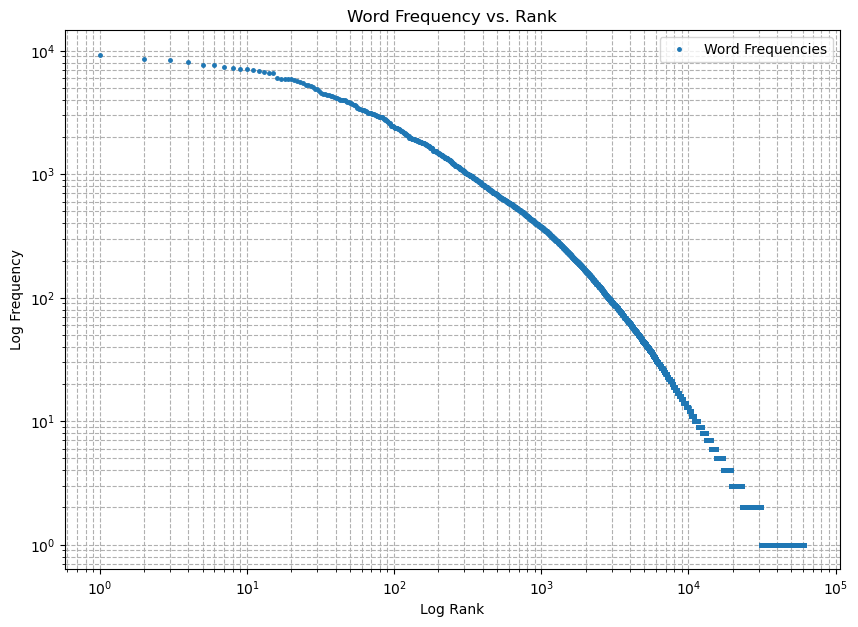

In [24]:
from nltk import *
freqdist = FreqDist(tokens_list)

def frequency_rank_plot(tokens_list):
    freqdist = FreqDist(tokens_list)
    words, frequencies = zip(*freqdist.most_common())
    print("words: ", words)
    ranks = np.arange(1, len(words) + 1)
    plt.figure(figsize=(10, 7))
    plt.loglog(ranks, frequencies, marker=".", linestyle='None', markersize=5, label='Word Frequencies')
    plt.title('Word Frequency vs. Rank')
    plt.xlabel('Log Rank')
    plt.ylabel('Log Frequency')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

frequency_rank_plot(tokens_list)

From the above plot, we see that the distribution of word frequencies in the US senate tweets follows a pattern that is common in natural language - namely that there are a small number of words (words with lower ranks) that are used frequently, and then there are a large number of words (with higher ranks) that are used infrequently.

### **Finding Collocations**

Before being able to compute term frequencies and inverse document frequencies, we need to create a tokens list that employs collocations. This can be done using a Chi-squared test as seen in the code below:

In [25]:
from collections import Counter
from scipy.stats import chi2

bigrams_list = list(bigrams(tokens_list))
bigram_counts = Counter(bigrams_list)

first_counts = Counter(bg[0] for bg in bigrams_list)
second_counts = Counter(bg[1] for bg in bigrams_list)
N = len(bigrams_list)

def compute_chi_squared(bigram):
    nii = bigram_counts[bigram]
    nio = first_counts[bigram[0]] - nii
    noi = second_counts[bigram[1]] - nii
    noo = N - (nii + nio + noi)
    
    R1 = nii + nio
    C1 = nii + noi
    
    eii = R1 * C1 / N
    eio = R1 * (N - C1) / N
    eoi = (N - R1) * C1 / N
    eno = (N - R1) * (N - C1) / N
    
    chi_squared = ((nii - eii)**2 / eii) + ((nio - eio)**2 / eio) + ((noi - eoi)**2 / eoi) + ((noo - eno)**2 / eno)
    p_value = chi2.sf(chi_squared, df=1)
    
    return chi_squared, p_value

collocations = [(bigram, count, compute_chi_squared(bigram)[1]) for bigram, count in bigram_counts.items() if count > 50 and compute_chi_squared(bigram)[1] < 0.001]

collocations.sort(key=lambda x: x[1], reverse=True)

print(f"Found {len(collocations)} collocations.")
print("Top 20 collocations:")
for collocation in collocations[:20]:
    print(collocation)

Found 1941 collocations.
Top 20 collocations:
(('president', 'biden'), 2067, 0.0)
(('health', 'care'), 2049, 0.0)
(('biden', 'administration'), 1690, 0.0)
(('american', 'people'), 1482, 0.0)
(('bipartisan', 'infrastructure'), 1475, 0.0)
(('im', 'proud'), 1427, 0.0)
(('across', 'country'), 1389, 0.0)
(('united', 'states'), 1340, 0.0)
(('look', 'forward'), 1267, 0.0)
(('make', 'sure'), 1241, 0.0)
(('american', 'rescue'), 1221, 0.0)
(('rescue', 'plan'), 1196, 0.0)
(('child', 'care'), 1142, 0.0)
(('president', 'bidens'), 1141, 0.0)
(('loved', 'ones'), 1133, 0.0)
(('small', 'businesses'), 1130, 0.0)
(('voting', 'rights'), 1098, 0.0)
(('climate', 'change'), 1093, 0.0)
(('infrastructure', 'bill'), 1072, 0.0)
(('build', 'back'), 941, 0.0)


We can now update our tokens list:

In [26]:
from nltk.tokenize import MWETokenizer
mwe_tokenizer = MWETokenizer([tuple(c[0]) for c in collocations], separator='_')

def tokenize(text):
    text = text.lower()
    text = re.sub(r'-', ' ', text)
    text = re.sub("'", '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.strip()]
    return mwe_tokenizer.tokenize(tokens)

df['tokens'] = df['text'].apply(tokenize)
tokens_list = df['tokens'].explode()
tokens_list = tokens_list.tolist()

### **Finding Term Frequency for communities**

We now wish to determine the term frequency for each community. This can be achieved using the following code:

In [27]:
from collections import Counter

def calculate_tf(tokens_list):
    tf_dict = Counter(tokens_list)
    total_count = len(tokens_list)
    for word in tf_dict:
        tf_dict[word] /= total_count
    return tf_dict

#Group tweets by community
df['community'] = None

for i, community in enumerate(communities):
    df.loc[df['username'].isin(community), 'community'] = i

community_texts = df.groupby('community')['tokens'].apply(lambda tokens_lists: sum(tokens_lists, [])).reset_index()
print(community_texts)

   community                                             tokens
0          0  [the, greatest, generations, investment, in, i...
1          1  [read, my, op_ed, in, journalstarnews, about, ...
2          2  [happy_th, birthday, to, the, usnavy, the, str...
3          3  [today, were, celebrating, years, of, the, hoo...
4          4  [celebrating, rockyourmocs, day, with, my, sis...


In [28]:
#Calculate the term-frequency (TF):
community_texts['tf'] = community_texts['tokens'].apply(calculate_tf)
community_texts['top_terms'] = community_texts['tf'].apply(lambda x: sorted(x.items(), key=lambda item: item[1], reverse=True)[:5])

for index, row in community_texts.iterrows():
    community = row['community']
    top_terms = row['top_terms']
    print(f"Community {community}:")
    for term, tf in top_terms:
        print(f" - {term}: {tf}")
    print("\n")


Community 0:
 - the: 0.05174191992927845
 - to: 0.04707557541107415
 - and: 0.0375965801433595
 - of: 0.02003674140991812
 - in: 0.018254278169358734


Community 1:
 - the: 0.050766427002196926
 - to: 0.050722738166566805
 - and: 0.03897044138206511
 - of: 0.019472738166566805
 - in: 0.017463051727581388


Community 2:
 - the: 0.050812145530305955
 - to: 0.0470898467969611
 - and: 0.03680865304451829
 - of: 0.020347671760014896
 - in: 0.018787627676188526


Community 3:
 - the: 0.05313933907713143
 - to: 0.041218136621613194
 - and: 0.03535108743106106
 - of: 0.02170763651915144
 - in: 0.01805821609629623


Community 4:
 - the: 0.05431331663820112
 - to: 0.04581556419418045
 - and: 0.036076154950386116
 - of: 0.024403533220868218
 - in: 0.01870343787000849




### **Finding Inverse Document Frequency for communities**

We now wish to determine the inverse document frequency for each community. This is achieved using the following code:

In [29]:
import numpy as np
doc_freq = Counter(word for tokens in community_texts['tokens'] for word in set(tokens))
N = len(community_texts)
idf_values = {word: np.log(N / doc_freq[word]) for word in doc_freq}

### **Finding TF-IDF for communities**

Using the term frequencies and inverse document frequencies computed for each community, we can now calculate the TF-IDF for each community

In [30]:
def calculate_tfidf(tf_dict, idf_values):
    return {word: tf * idf_values.get(word, 0) for word, tf in tf_dict.items()}

community_texts['tf_idf'] = community_texts['tf'].apply(lambda tf: calculate_tfidf(tf, idf_values))

aggregate_tf = defaultdict(Counter)
aggregate_tfidf = defaultdict(Counter)

# Aggregate scores
for _, row in community_texts.iterrows():
    aggregate_tf[row['community']].update(row['tf'])
    aggregate_tfidf[row['community']].update(row['tf_idf'])

communities_list = [0, 1, 2, 3, 4]

for community in communities_list:
    # Sort and select top 10 TF words
    top_tf_words = sorted(aggregate_tf[community].items(), key=lambda x: x[1], reverse=True)[:10]
    # Sort and select top 10 TF-IDF words
    top_tfidf_words = sorted(aggregate_tfidf[community].items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"Community {community}:")
    print("Top 10 TF Words:")
    for word, score in top_tf_words:
        print(f"  {word}: {score}")
    print("\nTop 10 TF-IDF Words:")
    for word, score in top_tfidf_words:
        print(f"  {word}: {score}")
    print("\n----------\n")

Community 0:
Top 10 TF Words:
  the: 0.05174191992927845
  to: 0.04707557541107415
  and: 0.0375965801433595
  of: 0.02003674140991812
  in: 0.018254278169358734
  a: 0.01738159240938544
  for: 0.0158464073062447
  our: 0.011401582786144594
  is: 0.011307823159040026
  we: 0.011228488089951544

Top 10 TF-IDF Words:
  cancelstudentdebt: 0.00032287459835432384
  new_mexicans: 0.0002603444710691315
  oregonians: 0.00020562238479345418
  coloradans: 0.00020064764967748353
  oregon: 0.00016684239494421205
  new_mexicos: 0.00016582450386568885
  new_mexico: 0.00014157919318609795
  federal_prohibition: 0.00013763433820852177
  new_jersey: 0.00012650642157742515
  colorados: 0.00012105188782195287

----------

Community 1:
Top 10 TF Words:
  the: 0.050766427002196926
  to: 0.050722738166566805
  and: 0.03897044138206511
  of: 0.019472738166566805
  in: 0.017463051727581388
  a: 0.016158627920910724
  for: 0.014760585180746954
  our: 0.013543539045336528
  is: 0.01018573996405033
  this: 0.010

### **Build WordClouds**